In [ ]:
import os
from time import time
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import roc_curve, auc, roc_auc_score,average_precision_score
import numpy as np
#from tensorflow.keras.layers import Dense, Dropout, Merge
from keras.layers import Concatenate
from keras.layers import Dense, Dropout
from keras.layers import Activation, Dense
import utils.tools as utils
from keras.regularizers import l2
from gensim.models import Word2Vec
import copy
import psutil
import h5py
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/xal2019/DeepFE-PPI

Cloning into 'DeepFE-PPI'...
remote: Enumerating objects: 441, done.
remote: Total 441 (delta 0), reused 0 (delta 0), pack-reused 441
Receiving objects: 100% (441/441), 27.87 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Error downloading object: model/dl/11188/swissProt_size_20_window_4_maxlen_850_batch_size_256_nb_epoch_45/round_0.h5 (1bae7ff): Smudge error: Error downloading model/dl/11188/swissProt_size_20_window_4_maxlen_850_batch_size_256_nb_epoch_45/round_0.h5 (1bae7ff18ea71ba864cefe852dcf02e93424fc2905f27befb1c4f64b4f1d5714): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/DeepFE-PPI/.git/lfs/logs/20231026T111121.425411935.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: model/dl/11188/swissProt_size_20_window_4_maxlen_850_batch_size_256_nb_epoch_45/round_0.h5: smudge filter lfs f

In [ ]:
cd DeepFE-PPI

/content/DeepFE-PPI


In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate

In [ ]:
from datetime import datetime
from time import time, sleep
import random
import sys

In [ ]:
def read_file(file_name):
    pro_swissProt = []
    with open(file_name, 'r') as fp:
        protein = ''
        for line in fp:
            if line.startswith('>sp|'):
                pro_swissProt.append(protein)
                protein = ''
            elif line.startswith('>sp|') == False:
                protein = protein+line.strip()

    return   pro_swissProt[1:]

In [ ]:
def get_res2vec_data():
    file_name = 'dataset/uniprot_sprot.fasta'
    pro_swissProt = read_file(file_name)

    return pro_swissProt

In [ ]:
def averagenum(num):
    nsum = 0
    for i in range(len(num)):
        nsum += num[i]
    return nsum / len(num)

In [ ]:
def max_min_avg_length(pro_swissProt):
    length = []
    for i in range(len(pro_swissProt)):
        length.append(len(pro_swissProt[i]))
    maxNum = max(length) #maxNum = 5
    minNum = min(length) #minNum = 1
    index_max = length.index(maxNum)
    index_min = length.index(minNum)
    avg = averagenum(length)
    return index_max,index_min,avg

In [ ]:
def token(dataset):
    token_dataset = []
    for i in range(len(dataset)):
        seq = []
        for j in range(len(dataset[i])):
            seq.append(dataset[i][j])

        token_dataset.append(seq)

    return  token_dataset

In [ ]:
def pandding_J(protein,maxlen):
    padded_protein = copy.deepcopy(protein)
    for i in range(len(padded_protein)):
        if len(padded_protein[i])<maxlen:
            for j in range(len(padded_protein[i]),maxlen):
                padded_protein[i].append('J')
    return padded_protein

In [ ]:
def protein_representation(wv,tokened_seq_protein,maxlen,size):
    represented_protein  = []
    for i in range(len(tokened_seq_protein)):
        temp_sentence = []
        for j in range(maxlen):
            if tokened_seq_protein[i][j]=='J':
                temp_sentence.extend(np.zeros(size))
            else:
                temp_sentence.extend(wv[tokened_seq_protein[i][j]])
        represented_protein.append(np.array(temp_sentence))
    return represented_protein

In [ ]:
def read_traingingData(file_name):
    # read sample from a file
    seq = []
    with open(file_name, 'r') as fp:
        i = 0
        for line in fp:
            if i%2==1:
                seq.append(line.split('\n')[0])
            i = i+1
    return   seq

In [ ]:
def get_training_dataset(wv,  maxlen,size):

    file_1 = 'dataset/training and test dataset/positive/Protein_A.txt'
    file_2 = 'dataset/training and test dataset/positive/Protein_B.txt'
    file_3 = 'dataset/training and test dataset/negative/Protein_A.txt'
    file_4 = 'dataset/training and test dataset/negative/Protein_B.txt'
    # positive seq protein A
    pos_seq_protein_A = read_traingingData(file_1)
    pos_seq_protein_B = read_traingingData(file_2)
    neg_seq_protein_A = read_traingingData(file_3)
    neg_seq_protein_B = read_traingingData(file_4)
    # put pos and neg together
    pos_neg_seq_protein_A = copy.deepcopy(pos_seq_protein_A)
    pos_neg_seq_protein_A.extend(neg_seq_protein_A)
    pos_neg_seq_protein_B = copy.deepcopy(pos_seq_protein_B)
    pos_neg_seq_protein_B.extend(neg_seq_protein_B)
    # token
    token_pos_neg_seq_protein_A = token(pos_neg_seq_protein_A)
    token_pos_neg_seq_protein_B = token(pos_neg_seq_protein_B)
    # padding
    tokened_token_pos_neg_seq_protein_A = pandding_J(token_pos_neg_seq_protein_A, maxlen)
    tokened_token_pos_neg_seq_protein_B = pandding_J(token_pos_neg_seq_protein_B,maxlen)
    # protein reprsentation
    feature_protein_A  = protein_representation(wv,tokened_token_pos_neg_seq_protein_A,maxlen,size)
    feature_protein_B  = protein_representation(wv,tokened_token_pos_neg_seq_protein_B,maxlen,size)
    feature_protein_AB = np.hstack((np.array(feature_protein_A),np.array(feature_protein_B)))
    mem_hstack = getMemorystate()
    #  creat label
    label = np.ones(len(feature_protein_A))
    label[len(feature_protein_AB)//2:] = 0

    return feature_protein_AB,label,mem_hstack

In [ ]:
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:
        os.makedirs(path)
        print("---  new folder...  ---")
        print("---  OK  ---")

    else:
        print("---  There is this folder!  ---")

In [ ]:
def getMemorystate():
    phymem = psutil.virtual_memory()
    line = "Memory: %5s%% %6s/%s"%(phymem.percent,
                                   str(int(phymem.used/1024/1024))+"M",
                                   str(int(phymem.total/1024/1024))+"M")
    return line

In [ ]:
def train_validation__vis(hist,i,plot_dir,db,actual, predicted):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    #fig, axes = plt.subplots(3, 1, figsize=(8, 12))  # Create a 3x1 grid
    # make a figure
    fig = plt.figure(figsize=(8, 12))
    # subplot loss
    ax1 = fig.add_subplot(311)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(312)
    ax2.plot(acc,label='train_accuracy')
    ax2.plot(val_acc,label='val_accuracy')
    ax2.set_xlabel('Epochs')

    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracyn  on Training and Validation Data')
    ax2.legend()

    # subplot confusion matrix
    ax3 = fig.add_subplot(313)
    cm = confusion_matrix(actual, predicted)

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', ax=ax3)
    ax3.set_ylabel('Prediction', fontsize=13)
    ax3.set_xlabel('Actual', fontsize=13)
    ax3.set_title('Confusion Matrix', fontsize=17)

    plt.tight_layout()
    plt.savefig(plot_dir + db+'/round_'+str(i)+'.png')

In [ ]:
def classify(size,window,maxlen,train_fea_protein_AB,train_label):
    time_start_classify = time()
    sg = 'swissProt_size_'+str(size)+'_window_'+str(window)
    db = sg+'_maxlen_'+str(maxlen)
    #db_dir= 'dataset/11188/different size represented data/size_'+str(size)
    plot_dir = "plots/"
    result_dir = "result/11188/performance/"
    model_dir = "model/dl/11188/"

    mkdir(plot_dir + db)
    #mkdir(result_dir + db)
    mkdir(model_dir + db)

    sequence_len = size*maxlen
    print(sequence_len)



    Y = utils.to_categorical(train_label)
    skf = StratifiedKFold(n_splits = 5,random_state= 20181031,shuffle= True)


    scores = []
    i = 0
    mem_cv = []
    for (train_index, test_index) in skf.split(train_fea_protein_AB,train_label):
        print("================")

        print(test_index)
        print(train_index)
        X_train, X_val, y_train, y_val = train_test_split(train_fea_protein_AB[train_index], Y[train_index],random_state= 20181031, test_size=0.1,shuffle= True)

        X_train_left = X_train[:,0:sequence_len]
        X_train_right = X_train[:,sequence_len:sequence_len*2]

        X_validation_left = X_val[:,0:sequence_len]
        X_validation_right = X_val[:,sequence_len:sequence_len*2]

        X_test_left = train_fea_protein_AB[:,0:sequence_len][test_index]
        X_test_right = train_fea_protein_AB[:,sequence_len:sequence_len*2][test_index]

        # turn to np.array
        X_train_left  = np.array(X_train_left)
        X_train_right  = np.array(X_train_right)

        X_test_left  = np.array(X_test_left)
        X_test_right  = np.array(X_test_right)

        X_validation_left  = np.array(X_validation_left)
        X_validation_right  = np.array(X_validation_right)
        # label
        y_test = Y[test_index]

        # feed data into model
        model =  merged_cnn(sequence_len)
        sgd = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9, decay=0.001)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        hist = model.fit([X_train_left, X_train_right], y_train,
                  validation_data=([X_validation_left,X_validation_right],y_val),
                  batch_size = 32,
                  epochs = 30,
                  verbose = 1)
        #mem_cv.append('round '+str(i)+' '+getMemorystate())
        #train_validation__vis(hist,i,plot_dir,db,y_test[:,1], label_predict_test)
        print('******   model created!  ******')
        model.save(model_dir + db+'/round_'+str(i)+'.h5')

        predictions_test = model.predict([X_test_left, X_test_right])

        #cm = confusion_matrix_1(y_test[:,1], label_predict_test)

        auc_test = roc_auc_score(y_test[:,1], predictions_test[:,1])
        pr_test = average_precision_score(y_test[:,1], predictions_test[:,1])

        label_predict_test = utils.categorical_probas_to_classes(predictions_test)
        print(label_predict_test)
        print(y_test[:,1])
        train_validation__vis(hist,i,plot_dir,db,y_test[:,1], label_predict_test)
        tp_test,fp_test,tn_test,fn_test,accuracy_test, precision_test, sensitivity_test,recall_test, specificity_test, MCC_test, f1_score_test,_,_,_= utils.calculate_performace(len(label_predict_test), label_predict_test, y_test[:,1])
        print(db+'    test:'+str(i))
        print('\ttp=%0.0f,fp=%0.0f,tn=%0.0f,fn=%0.0f'%(tp_test,fp_test,tn_test,fn_test))
        print('\tacc=%0.4f,pre=%0.4f,rec=%0.4f,sp=%0.4f,mcc=%0.4f,f1=%0.4f'
              % (accuracy_test, precision_test, recall_test, specificity_test, MCC_test, f1_score_test))
        print('\tauc=%0.4f,pr=%0.4f'%(auc_test,pr_test))
        scores.append([accuracy_test,precision_test, recall_test, f1_score_test, auc_test,pr_test])
        #cm = confusion_matrix_1(y_test[:,1], label_predict_test)


        i=i+1
        #K.clear_session()
        #tf.reset_default_graph()

    sc= pd.DataFrame(scores)
    sc.to_csv(index=False)
    scores_array = np.array(scores)
    print (db+'_5cv:')
    print(("accuracy=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[0]*100,np.std(scores_array, axis=0)[0]*100)))
    print(("precision=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[1]*100,np.std(scores_array, axis=0)[1]*100)))
    print("recall=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[2]*100,np.std(scores_array, axis=0)[2]*100))

    print("f1_score=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[3]*100,np.std(scores_array, axis=0)[3]*100))
    print("roc_auc=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[4]*100,np.std(scores_array, axis=0)[4]*100))
    print("roc_pr=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[5]*100,np.std(scores_array, axis=0)[5]*100))
    time_end_classify = time()

    # memory and time for classify
    print('Time of create db('+db+'):', time_end_classify - time_start_classify)




In [ ]:
from tensorflow.keras import Model

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical

In [ ]:
def merged_cnn(sequence_len):
    # Left model
    left_input = Input(shape=(sequence_len,1))
    left_output = Conv1D(512,kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(left_input)
    left_output=MaxPooling1D(2)(left_output)
    left_output = BatchNormalization()(left_output)
    left_output = Dropout(0.5)(left_output)
    left_output = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(left_output)
    left_output = BatchNormalization()(left_output)
    left_output = Dropout(0.5)(left_output)
    #left_output = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(left_output)
    #left_output = BatchNormalization()(left_output)
    #left_output = Dropout(0.5)(left_output)
    left_output = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(left_output)
    left_output = BatchNormalization()(left_output)
    left_output = Dropout(0.5)(left_output)

    # Right model
    right_input = Input(shape=(sequence_len,1))
    right_output = Conv1D(512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(right_input)
    right_output=MaxPooling1D(2)(right_output)
    right_output = BatchNormalization()(right_output)
    right_output = Dropout(0.5)(right_output)
    right_output = Dense(128,  activation='relu', kernel_regularizer=l2(0.01))(right_output)
    right_output = BatchNormalization()(right_output)
    right_output = Dropout(0.5)(right_output)
    #right_output = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(right_output)
    #right_output = BatchNormalization()(right_output)
    #right_output = Dropout(0.5)(right_output)
    right_output = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(right_output)
    right_output = BatchNormalization()(right_output)
    right_output = Dropout(0.5)(right_output)
    # Concatenate the output tensors of the two models
    merged_output = concatenate([left_output, right_output])

    merged_output = Flatten()(merged_output)

    # Final classification layers
    merged_output = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(merged_output)
    merged_output = BatchNormalization()(merged_output)
    merged_output = Dropout(0.5)(merged_output)
    merged_output = Dense(2, activation='softmax')(merged_output)

    # Create the model
    model = Model(inputs=[left_input, right_input], outputs=merged_output)

    return model

In [ ]:
mm=merged_cnn(2200)
mm.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 2200, 1)]            0         []                            
                                                                                                  
 input_44 (InputLayer)       [(None, 2200, 1)]            0         []                            
                                                                                                  
 conv1d_42 (Conv1D)          (None, 2198, 512)            2048      ['input_43[0][0]']            
                                                                                                  
 conv1d_43 (Conv1D)          (None, 2198, 512)            2048      ['input_44[0][0]']            
                                                                                           

# proposed Model

In [ ]:
size=4
window=4
maxlen=550
data_start_maxlen = time()
sg = 'wv_swissProt_size_'+str(size)+'_window_'+str(window)
model_wv = Word2Vec.load('model/word2vec/'+sg+'.model')
train_fea_protein_AB,train_label,mem_hstack= get_training_dataset(model_wv.wv, maxlen,size )
scaler = StandardScaler().fit(train_fea_protein_AB)
train_fea_protein_AB = scaler.transform(train_fea_protein_AB)
train_fea_protein_AB = np.array(train_fea_protein_AB)
data_end_maxlen = time()
print('Time ', data_end_maxlen - data_start_maxlen)
print('classify:')

Time  50.88502478599548
classify:


---  There is this folder!  ---
---  There is this folder!  ---
2200
[    1     3     5 ... 11182 11183 11184]
[    0     2     4 ... 11185 11186 11187]


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
252/252 [==============================] - 26s 96ms/step - loss: 5.5011 - accuracy: 0.5394 - val_loss: 3.7270 - val_accuracy: 0.4972
Epoch 2/30
252/252 [==============================] - 23s 93ms/step - loss: 2.8461 - accuracy: 0.6826 - val_loss: 2.3318 - val_accuracy: 0.5844
Epoch 3/30
252/252 [==============================] - 23s 93ms/step - loss: 1.8623 - accuracy: 0.7837 - val_loss: 1.7396 - val_accuracy: 0.6916
Epoch 4/30
252/252 [==============================] - 23s 93ms/step - loss: 1.4068 - accuracy: 0.8289 - val_loss: 1.2241 - val_accuracy: 0.8581
Epoch 5/30
252/252 [==============================] - 23s 93ms/step - loss: 1.1427 - accuracy: 0.8467 - val_loss: 1.0185 - val_accuracy: 0.8804
Epoch 6/30
252/252 [==============================] - 24s 93ms/step - loss: 0.9754 - accuracy: 0.8731 - val_loss: 0.8551 - val_accuracy: 0.9084
Epoch 7/30
252/252 [==============================] - 24s 93ms/step - loss: 0.8740 - accuracy: 0.8819 - val_loss: 0.8310 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 2s 28ms/step
[1 0 1 ... 0 0 0]
[1. 1. 1. ... 0. 0. 0.]
swissProt_size_4_window_4_maxlen_550    test:0
	tp=988,fp=32,tn=1087,fn=131
	acc=0.9272,pre=0.9686,rec=0.8829,sp=0.9714,mcc=0.8577,f1=0.9238
	auc=0.9779,pr=0.9817
[   10    13    18 ... 11171 11175 11185]
[    0     1     2 ... 11184 11186 11187]


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
252/252 [==============================] - 27s 99ms/step - loss: 5.6932 - accuracy: 0.5354 - val_loss: 3.8399 - val_accuracy: 0.5464
Epoch 2/30
252/252 [==============================] - 24s 97ms/step - loss: 2.9101 - accuracy: 0.5863 - val_loss: 2.2734 - val_accuracy: 0.5497
Epoch 3/30
252/252 [==============================] - 24s 94ms/step - loss: 1.8801 - accuracy: 0.7179 - val_loss: 1.5500 - val_accuracy: 0.7911
Epoch 4/30
252/252 [==============================] - 24s 94ms/step - loss: 1.3804 - accuracy: 0.7955 - val_loss: 1.2210 - val_accuracy: 0.8302
Epoch 5/30
252/252 [==============================] - 24s 95ms/step - loss: 1.1422 - accuracy: 0.8319 - val_loss: 1.0495 - val_accuracy: 0.8670
Epoch 6/30
252/252 [==============================] - 23s 93ms/step - loss: 0.9932 - accuracy: 0.8616 - val_loss: 0.9092 - val_accuracy: 0.8838
Epoch 7/30
252/252 [==============================] - 24s 95ms/step - loss: 0.8821 - accuracy: 0.8770 - val_loss: 0.8042 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 2s 29ms/step
[0 1 1 ... 0 0 0]
[1. 1. 1. ... 0. 0. 0.]
swissProt_size_4_window_4_maxlen_550    test:0
	tp=1012,fp=58,tn=1061,fn=107
	acc=0.9263,pre=0.9458,rec=0.9044,sp=0.9482,mcc=0.8534,f1=0.9246
	auc=0.9716,pr=0.9778
[    4     6     9 ... 11176 11177 11187]
[    0     1     2 ... 11184 11185 11186]


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
252/252 [==============================] - 26s 95ms/step - loss: 6.7543 - accuracy: 0.5460 - val_loss: 4.5933 - val_accuracy: 0.5073
Epoch 2/30
252/252 [==============================] - 23s 93ms/step - loss: 3.4420 - accuracy: 0.5983 - val_loss: 2.6684 - val_accuracy: 0.5777
Epoch 3/30
252/252 [==============================] - 23s 93ms/step - loss: 2.1319 - accuracy: 0.7460 - val_loss: 1.8087 - val_accuracy: 0.7777
Epoch 4/30
252/252 [==============================] - 24s 96ms/step - loss: 1.5404 - accuracy: 0.8171 - val_loss: 1.3514 - val_accuracy: 0.8246
Epoch 5/30
252/252 [==============================] - 23s 93ms/step - loss: 1.2147 - accuracy: 0.8523 - val_loss: 1.0413 - val_accuracy: 0.8961
Epoch 6/30
252/252 [==============================] - 23s 93ms/step - loss: 1.0250 - accuracy: 0.8687 - val_loss: 0.9142 - val_accuracy: 0.8939
Epoch 7/30
252/252 [==============================] - 23s 93ms/step - loss: 0.9049 - accuracy: 0.8848 - val_loss: 0.8285 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 2s 28ms/step
[1 0 1 ... 0 0 0]
[1. 1. 1. ... 0. 0. 0.]
swissProt_size_4_window_4_maxlen_550    test:0
	tp=991,fp=57,tn=1062,fn=128
	acc=0.9173,pre=0.9456,rec=0.8856,sp=0.9491,mcc=0.8364,f1=0.9146
	auc=0.9715,pr=0.9770
[    0    11    16 ... 11166 11174 11181]
[    1     2     3 ... 11185 11186 11187]


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
252/252 [==============================] - 26s 95ms/step - loss: 5.5895 - accuracy: 0.5325 - val_loss: 3.8037 - val_accuracy: 0.4922
Epoch 2/30
252/252 [==============================] - 24s 93ms/step - loss: 2.9869 - accuracy: 0.6185 - val_loss: 2.8253 - val_accuracy: 0.4922
Epoch 3/30
252/252 [==============================] - 24s 95ms/step - loss: 1.9604 - accuracy: 0.7219 - val_loss: 1.7554 - val_accuracy: 0.6462
Epoch 4/30
252/252 [==============================] - 24s 96ms/step - loss: 1.4638 - accuracy: 0.7923 - val_loss: 1.2761 - val_accuracy: 0.8114
Epoch 5/30
252/252 [==============================] - 24s 96ms/step - loss: 1.1622 - accuracy: 0.8307 - val_loss: 0.9759 - val_accuracy: 0.8929
Epoch 6/30
252/252 [==============================] - 24s 96ms/step - loss: 1.0025 - accuracy: 0.8540 - val_loss: 0.8554 - val_accuracy: 0.9118
Epoch 7/30
252/252 [==============================] - 24s 93ms/step - loss: 0.8895 - accuracy: 0.8680 - val_loss: 0.7914 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 2s 28ms/step
[1 0 1 ... 0 0 0]
[1. 1. 1. ... 0. 0. 0.]
swissProt_size_4_window_4_maxlen_550    test:0
	tp=1004,fp=32,tn=1086,fn=115
	acc=0.9343,pre=0.9691,rec=0.8972,sp=0.9714,mcc=0.8710,f1=0.9318
	auc=0.9804,pr=0.9840
[    2    20    34 ... 11179 11180 11186]
[    0     1     3 ... 11184 11185 11187]


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
252/252 [==============================] - 26s 97ms/step - loss: 5.5508 - accuracy: 0.5623 - val_loss: 3.9231 - val_accuracy: 0.5078
Epoch 2/30
252/252 [==============================] - 24s 96ms/step - loss: 2.9599 - accuracy: 0.7022 - val_loss: 2.4713 - val_accuracy: 0.6685
Epoch 3/30
252/252 [==============================] - 24s 94ms/step - loss: 1.9621 - accuracy: 0.8015 - val_loss: 1.7180 - val_accuracy: 0.7857
Epoch 4/30
252/252 [==============================] - 24s 93ms/step - loss: 1.4598 - accuracy: 0.8403 - val_loss: 1.2489 - val_accuracy: 0.8783
Epoch 5/30
252/252 [==============================] - 24s 96ms/step - loss: 1.1650 - accuracy: 0.8674 - val_loss: 1.0091 - val_accuracy: 0.8962
Epoch 6/30
252/252 [==============================] - 24s 95ms/step - loss: 1.0133 - accuracy: 0.8713 - val_loss: 0.9020 - val_accuracy: 0.9029
Epoch 7/30
252/252 [==============================] - 24s 95ms/step - loss: 0.8865 - accuracy: 0.8831 - val_loss: 0.8329 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 2s 28ms/step
[1 1 1 ... 0 0 0]
[1. 1. 1. ... 0. 0. 0.]
swissProt_size_4_window_4_maxlen_550    test:0
	tp=993,fp=37,tn=1082,fn=125
	acc=0.9276,pre=0.9641,rec=0.8882,sp=0.9669,mcc=0.8578,f1=0.9246
	auc=0.9753,pr=0.9807
swissProt_size_4_window_4_maxlen_550_5cv:
accuracy=92.65% (+/- 0.54%)
precision=95.86% (+/- 1.07%)
recall=89.17% (+/- 0.80%)
f1_score=92.39% (+/- 0.55%)
roc_auc=97.54% (+/- 0.35%)
roc_pr=98.02% (+/- 0.26%)
Time of create db(swissProt_size_4_window_4_maxlen_550): 3773.0296947956085


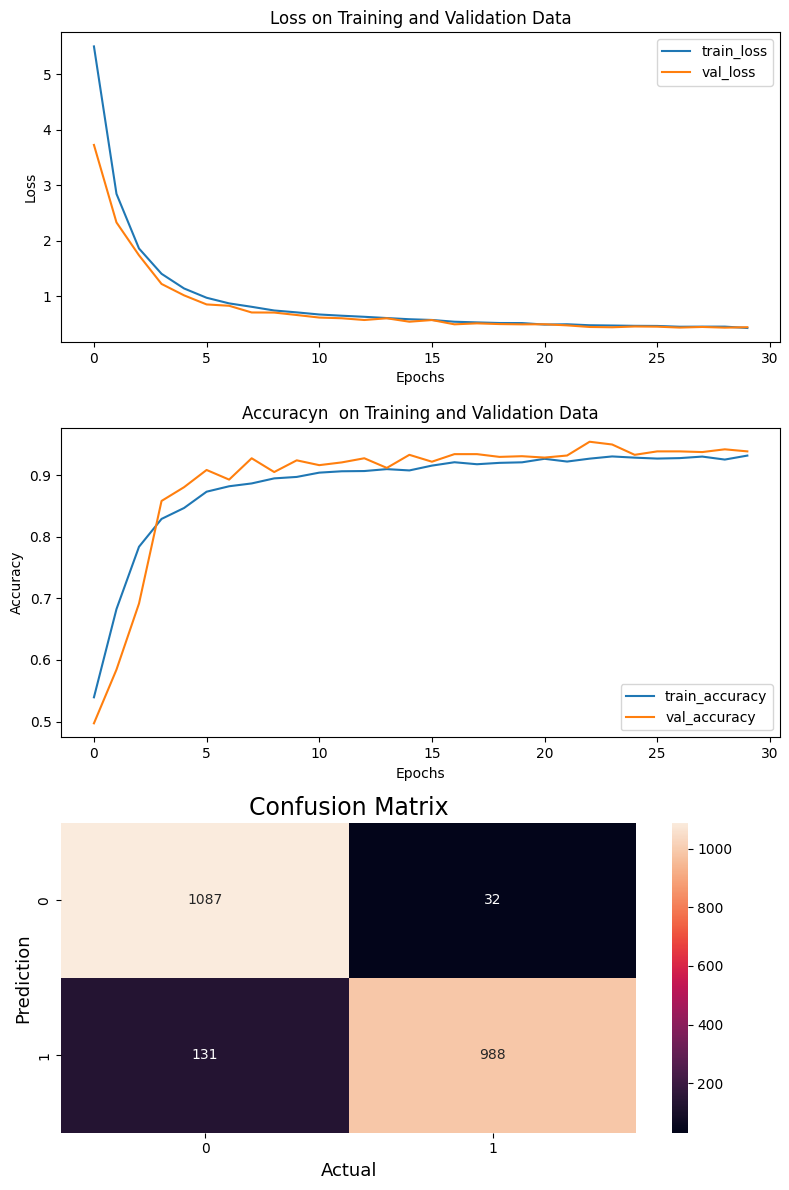

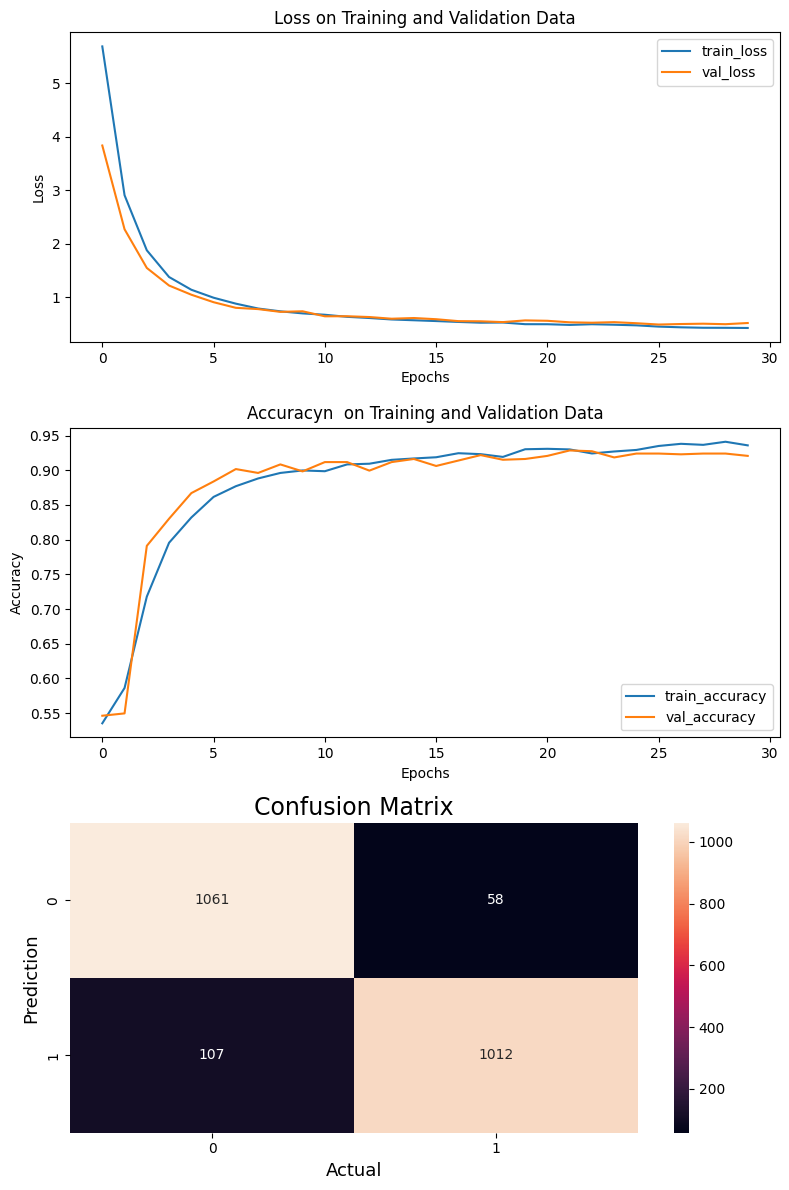

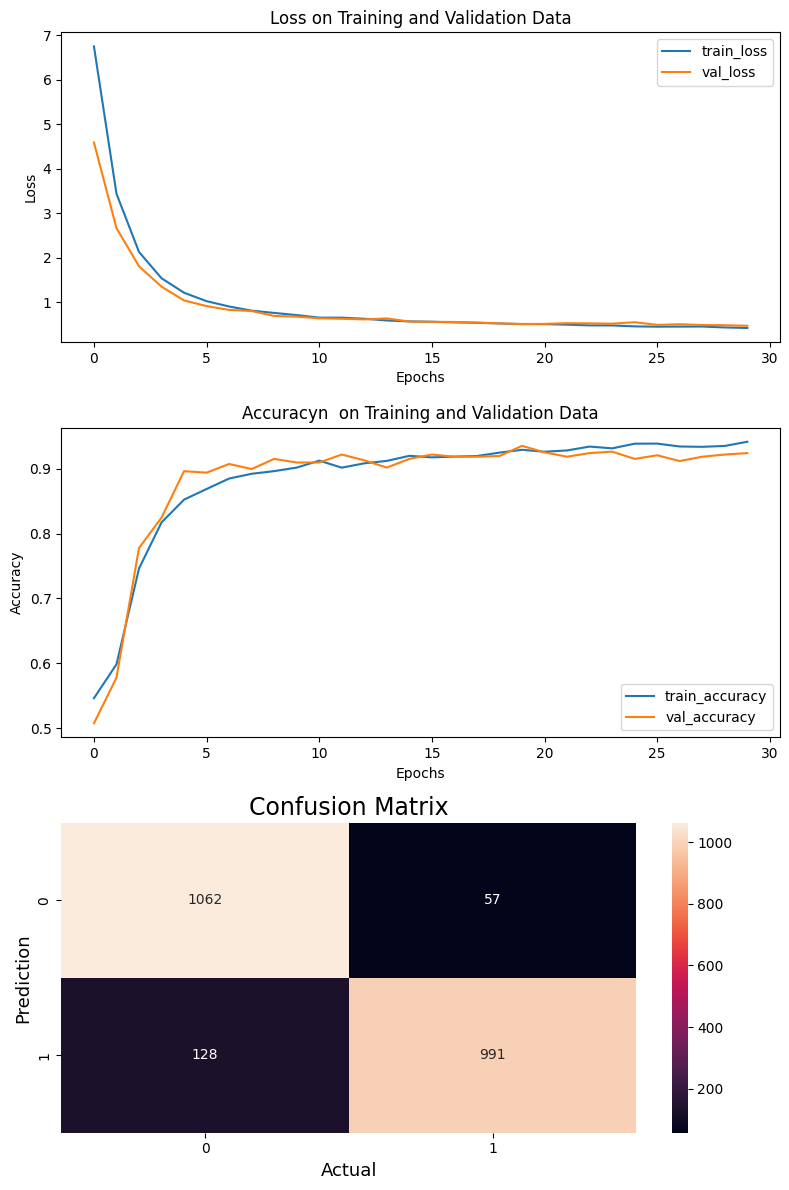

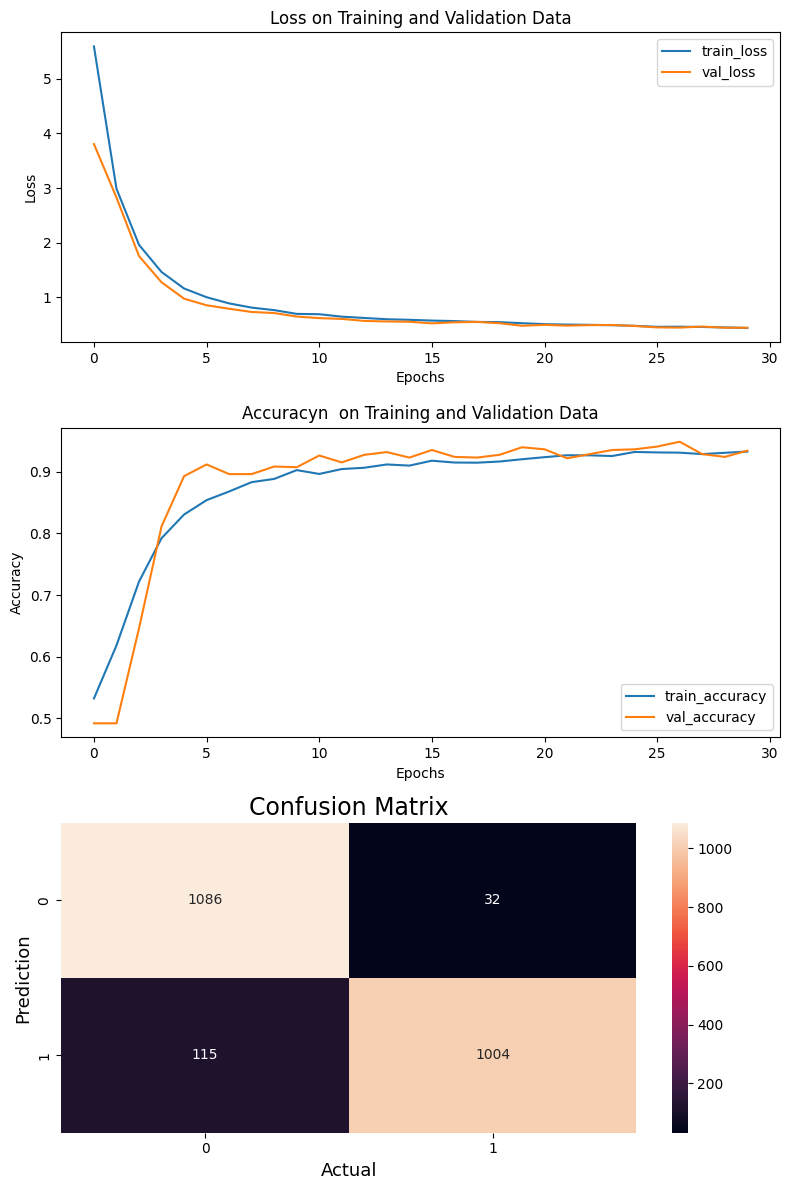

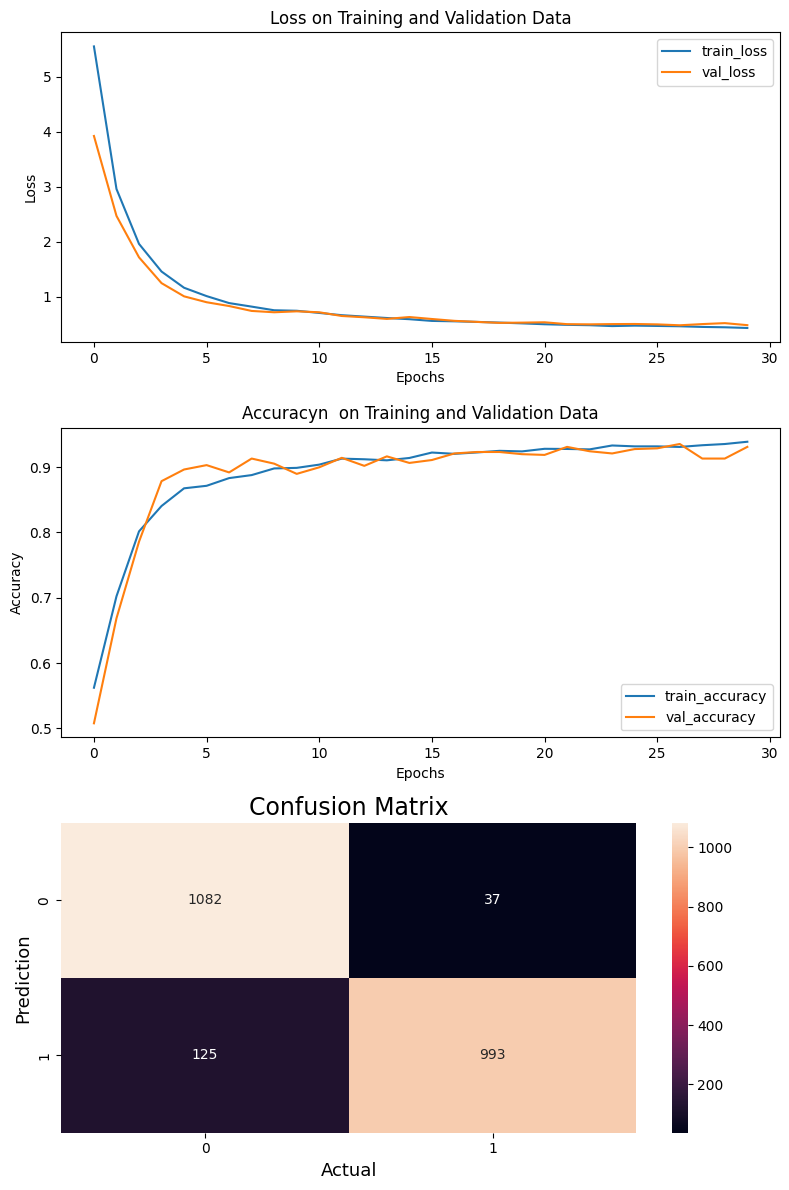

In [ ]:
classify(size,window,maxlen,train_fea_protein_AB,train_label)

In [ ]:
import scipy.io as sio
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.metrics import roc_curve, auc
import utils.tools as utils
import os
import sys

# SVC

In [ ]:
def new_classify(size,window,maxlen,train_fea_protein_AB,train_label):
    sequence_len = size*maxlen
    print(sequence_len)
    result_dir="/content"
    #Y = utils.to_categorical(train_label)
    Y = train_label
    #Y = train_label
    skf = StratifiedKFold(n_splits = 5,random_state= 20181031,shuffle= True)

    scores = []
    i = 0
    mem_cv = []
    for (train_index, test_index) in skf.split(train_fea_protein_AB,train_label):
        print("================")

        print(test_index)
        print(train_index)
        X_train, X_val, y_train, y_val = train_test_split(train_fea_protein_AB[train_index], Y[train_index],random_state= 20181031, test_size=0.1,shuffle= True)

        X_train_left = X_train[:,0:sequence_len*2]
        #X_train_right = X_train[:,sequence_len:sequence_len*2]

        X_validation_left = X_val[:,0:sequence_len*2]
        #X_validation_right = X_val[:,sequence_len:sequence_len*2]

        X_test_left = train_fea_protein_AB[:,0:sequence_len*2][test_index]
        #X_test_right = train_fea_protein_AB[:,sequence_len:sequence_len*2][test_index]

        # turn to np.array
        X_train_left  = np.array(X_train_left)
        #X_train_right  = np.array(X_train_right)

        X_test_left  = np.array(X_test_left)
        #X_test_right  = np.array(X_test_right)

        X_validation_left  = np.array(X_validation_left)
        #X_validation_right  = np.array(X_validation_right)
        # label
        y_test = Y[test_index]

        print(X_train_left.shape)
        print(y_train.shape)


        cv_clf = SVC()

        X_train_enc=cv_clf.fit(X_train_left, y_train)




        # feed data into model
        #model =  merged_DBN(sequence_len)
        #sgd = SGD(lr=0.01, momentum=0.9, decay=0.001)
        #model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        #hist = model.fit([X_train_left, X_train_right], y_train,
                  #validation_data=([X_validation_left,X_validation_right],y_val),
                  #batch_size = 128,
                  #epochs = 45,
                  #verbose = 1)
        #mem_cv.append('round '+str(i)+' '+getMemorystate())
        #train_validation__vis(hist,i,plot_dir,db)
        print('******   model created!  ******')
        #model.save(model_dir + db+'/round_'+str(i)+'.h5')

        predictions_test = cv_clf.predict(X_test_left)

        acc=accuracy_score(y_test,predictions_test)
        pre=precision_score(y_test,predictions_test)
        recall=recall_score(y_test,predictions_test)
        f1=f1_score(y_test,predictions_test)

        print("accuarcy: ",acc)
        print("precision: ",pre)
        print("recall: ",recall)
        print("f1 score: ", f1)


        auc_test = roc_auc_score(y_test, predictions_test)
        print("auc_test: ",auc_test)
        pr_test = average_precision_score(y_test, predictions_test)
        print("pr_test: ",pr_test)
        #label_predict_test = utils.categorical_probas_to_classes(predictions_test)
        #tp_test,fp_test,tn_test,fn_test,accuracy_test, precision_test, sensitivity_test,recall_test, specificity_test, MCC_test, f1_score_test,_,_,_= utils.calculate_performace(len(label_predict_test), label_predict_test, y_test[:,1])
        #print(db+'    test:'+str(i))
        #print('\ttp=%0.0f,fp=%0.0f,tn=%0.0f,fn=%0.0f'%(tp_test,fp_test,tn_test,fn_test))
        #print('\tacc=%0.4f,pre=%0.4f,rec=%0.4f,sp=%0.4f,mcc=%0.4f,f1=%0.4f'
             # % (accuracy_test, precision_test, recall_test, specificity_test, MCC_test, f1_score_test))
        #print('\tauc=%0.4f,pr=%0.4f'%(auc_test,pr_test))
        #scores.append([accuracy_test,precision_test, recall_test,specificity_test, MCC_test, f1_score_test, auc_test,pr_test])

        scores.append([acc,pre, recall, f1, auc_test,pr_test])

        #i=i+1
        #K.clear_session()
        #tf.reset_default_graph()
    sc= pd.DataFrame(scores)
    sc.to_csv(index=False)
    scores_array = np.array(scores)

    print(("accuracy=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[0]*100,np.std(scores_array, axis=0)[0]*100)))
    print(("precision=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[1]*100,np.std(scores_array, axis=0)[1]*100)))
    print("recall=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[2]*100,np.std(scores_array, axis=0)[2]*100))

    print("f1_score=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[3]*100,np.std(scores_array, axis=0)[3]*100))
    print("roc_auc=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[4]*100,np.std(scores_array, axis=0)[4]*100))
    print("roc_pr=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[5]*100,np.std(scores_array, axis=0)[5]*100))

In [ ]:
import tensorflow as tf
from datetime import datetime
from time import time, sleep
import random
import sys

In [ ]:
size=4
window=4
maxlen=550
data_start_maxlen = time()
sg = 'wv_swissProt_size_'+str(size)+'_window_'+str(window)
model_wv = Word2Vec.load('model/word2vec/'+sg+'.model')
train_fea_protein_AB,train_label,mem_hstack= get_training_dataset(model_wv.wv, maxlen,size )
scaler = StandardScaler().fit(train_fea_protein_AB)
train_fea_protein_AB = scaler.transform(train_fea_protein_AB)
train_fea_protein_AB = np.array(train_fea_protein_AB)
data_end_maxlen = time()
print('Time ', data_end_maxlen - data_start_maxlen)
print('classify:')
#new_classify(size,window,maxlen,train_fea_protein_AB,train_label)

In [ ]:
new_classify(size,window,maxlen,train_fea_protein_AB,train_label)

2200
[    1     3     5 ... 11182 11183 11184]
[    0     2     4 ... 11185 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8811438784629133
precision:  0.8997188378631678
recall:  0.8579088471849866
f1 score:  0.8783165599268068
auc_test:  0.8811438784629133
pr_test:  0.8429223273893127
[   10    13    18 ... 11171 11175 11185]
[    0     1     2 ... 11184 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8820375335120644
precision:  0.9036827195467422
recall:  0.8552278820375335
f1 score:  0.8787878787878788
auc_test:  0.8820375335120643
pr_test:  0.845240717253112
[    4     6     9 ... 11176 11177 11187]
[    0     1     2 ... 11184 11185 11186]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8927613941018767
precision:  0.9238187078109933
recall:  0.8561215370866846
f1 score:  0.888682745825603
auc_test:  0.8927613941018767
pr_test:  0.86284032357724
[    0    11    16 ... 11166 11174 11181]
[    1     2

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def new_classify1(size,window,maxlen,train_fea_protein_AB,train_label):
    sequence_len = size*maxlen
    print(sequence_len)
    result_dir="/content"
    #Y = utils.to_categorical(train_label)
    Y = train_label
    #Y = train_label
    skf = StratifiedKFold(n_splits = 5,random_state= 20181031,shuffle= True)

    scores = []
    i = 0
    mem_cv = []
    for (train_index, test_index) in skf.split(train_fea_protein_AB,train_label):
        print("================")

        print(test_index)
        print(train_index)
        X_train, X_val, y_train, y_val = train_test_split(train_fea_protein_AB[train_index], Y[train_index],random_state= 20181031, test_size=0.1,shuffle= True)

        X_train_left = X_train[:,0:sequence_len*2]
        #X_train_right = X_train[:,sequence_len:sequence_len*2]

        X_validation_left = X_val[:,0:sequence_len*2]
        #X_validation_right = X_val[:,sequence_len:sequence_len*2]

        X_test_left = train_fea_protein_AB[:,0:sequence_len*2][test_index]
        #X_test_right = train_fea_protein_AB[:,sequence_len:sequence_len*2][test_index]

        # turn to np.array
        X_train_left  = np.array(X_train_left)
        #X_train_right  = np.array(X_train_right)

        X_test_left  = np.array(X_test_left)
        #X_test_right  = np.array(X_test_right)

        X_validation_left  = np.array(X_validation_left)
        #X_validation_right  = np.array(X_validation_right)
        # label
        y_test = Y[test_index]

        print(X_train_left.shape)
        print(y_train.shape)


        cv_clf = KNeighborsClassifier()

        X_train_enc=cv_clf.fit(X_train_left, y_train)




        # feed data into model
        #model =  merged_DBN(sequence_len)
        #sgd = SGD(lr=0.01, momentum=0.9, decay=0.001)
        #model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        #hist = model.fit([X_train_left, X_train_right], y_train,
                  #validation_data=([X_validation_left,X_validation_right],y_val),
                  #batch_size = 128,
                  #epochs = 45,
                  #verbose = 1)
        #mem_cv.append('round '+str(i)+' '+getMemorystate())
        #train_validation__vis(hist,i,plot_dir,db)
        print('******   model created!  ******')
        #model.save(model_dir + db+'/round_'+str(i)+'.h5')

        predictions_test = cv_clf.predict(X_test_left)

        acc=accuracy_score(y_test,predictions_test)
        pre=precision_score(y_test,predictions_test)
        recall=recall_score(y_test,predictions_test)
        f1=f1_score(y_test,predictions_test)

        print("accuarcy: ",acc)
        print("precision: ",pre)
        print("recall: ",recall)
        print("f1 score: ", f1)


        auc_test = roc_auc_score(y_test, predictions_test)
        print("auc_test: ",auc_test)
        pr_test = average_precision_score(y_test, predictions_test)
        print("pr_test: ",pr_test)
        #label_predict_test = utils.categorical_probas_to_classes(predictions_test)
        #tp_test,fp_test,tn_test,fn_test,accuracy_test, precision_test, sensitivity_test,recall_test, specificity_test, MCC_test, f1_score_test,_,_,_= utils.calculate_performace(len(label_predict_test), label_predict_test, y_test[:,1])
        #print(db+'    test:'+str(i))
        #print('\ttp=%0.0f,fp=%0.0f,tn=%0.0f,fn=%0.0f'%(tp_test,fp_test,tn_test,fn_test))
        #print('\tacc=%0.4f,pre=%0.4f,rec=%0.4f,sp=%0.4f,mcc=%0.4f,f1=%0.4f'
             # % (accuracy_test, precision_test, recall_test, specificity_test, MCC_test, f1_score_test))
        #print('\tauc=%0.4f,pr=%0.4f'%(auc_test,pr_test))
        #scores.append([accuracy_test,precision_test, recall_test,specificity_test, MCC_test, f1_score_test, auc_test,pr_test])

        scores.append([acc,pre, recall, f1, auc_test,pr_test])

        #i=i+1
        #K.clear_session()
        #tf.reset_default_graph()
    sc= pd.DataFrame(scores)
    sc.to_csv(index=False)
    scores_array = np.array(scores)

    print(("accuracy=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[0]*100,np.std(scores_array, axis=0)[0]*100)))
    print(("precision=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[1]*100,np.std(scores_array, axis=0)[1]*100)))
    print("recall=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[2]*100,np.std(scores_array, axis=0)[2]*100))

    print("f1_score=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[3]*100,np.std(scores_array, axis=0)[3]*100))
    print("roc_auc=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[4]*100,np.std(scores_array, axis=0)[4]*100))
    print("roc_pr=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[5]*100,np.std(scores_array, axis=0)[5]*100))

In [ ]:
new_classify1(size,window,maxlen,train_fea_protein_AB,train_label)

2200
[    1     3     5 ... 11182 11183 11184]
[    0     2     4 ... 11185 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8145665773011618
precision:  0.8636363636363636
recall:  0.7470956210902592
f1 score:  0.8011499760421659
auc_test:  0.8145665773011618
pr_test:  0.7716711349419125
[   10    13    18 ... 11171 11175 11185]
[    0     1     2 ... 11184 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.7998212689901698
precision:  0.8595927116827439
recall:  0.7167113494191242
f1 score:  0.7816764132553606
auc_test:  0.7998212689901697
pr_test:  0.7577241776314214
[    4     6     9 ... 11176 11177 11187]
[    0     1     2 ... 11184 11185 11186]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8127792672028596
precision:  0.8731343283582089
recall:  0.7319034852546917
f1 score:  0.7963052989790957
auc_test:  0.8127792672028598
pr_test:  0.7730983153935417
[    0    11    16 ... 11166 11174 11181]
[    1  

# DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def new_classify2(size,window,maxlen,train_fea_protein_AB,train_label):
    sequence_len = size*maxlen
    print(sequence_len)
    result_dir="/content"
    #Y = utils.to_categorical(train_label)
    Y = train_label
    #Y = train_label
    skf = StratifiedKFold(n_splits = 5,random_state= 20181031,shuffle= True)

    scores = []
    i = 0
    mem_cv = []
    for (train_index, test_index) in skf.split(train_fea_protein_AB,train_label):
        print("================")

        print(test_index)
        print(train_index)
        X_train, X_val, y_train, y_val = train_test_split(train_fea_protein_AB[train_index], Y[train_index],random_state= 20181031, test_size=0.1,shuffle= True)

        X_train_left = X_train[:,0:sequence_len*2]
        #X_train_right = X_train[:,sequence_len:sequence_len*2]

        X_validation_left = X_val[:,0:sequence_len*2]
        #X_validation_right = X_val[:,sequence_len:sequence_len*2]

        X_test_left = train_fea_protein_AB[:,0:sequence_len*2][test_index]
        #X_test_right = train_fea_protein_AB[:,sequence_len:sequence_len*2][test_index]

        # turn to np.array
        X_train_left  = np.array(X_train_left)
        #X_train_right  = np.array(X_train_right)

        X_test_left  = np.array(X_test_left)
        #X_test_right  = np.array(X_test_right)

        X_validation_left  = np.array(X_validation_left)
        #X_validation_right  = np.array(X_validation_right)
        # label
        y_test = Y[test_index]

        print(X_train_left.shape)
        print(y_train.shape)


        cv_clf = DecisionTreeClassifier()

        X_train_enc=cv_clf.fit(X_train_left, y_train)




        # feed data into model
        #model =  merged_DBN(sequence_len)
        #sgd = SGD(lr=0.01, momentum=0.9, decay=0.001)
        #model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        #hist = model.fit([X_train_left, X_train_right], y_train,
                  #validation_data=([X_validation_left,X_validation_right],y_val),
                  #batch_size = 128,
                  #epochs = 45,
                  #verbose = 1)
        #mem_cv.append('round '+str(i)+' '+getMemorystate())
        #train_validation__vis(hist,i,plot_dir,db)
        print('******   model created!  ******')
        #model.save(model_dir + db+'/round_'+str(i)+'.h5')

        predictions_test = cv_clf.predict(X_test_left)

        acc=accuracy_score(y_test,predictions_test)
        pre=precision_score(y_test,predictions_test)
        recall=recall_score(y_test,predictions_test)
        f1=f1_score(y_test,predictions_test)

        print("accuarcy: ",acc)
        print("precision: ",pre)
        print("recall: ",recall)
        print("f1 score: ", f1)


        auc_test = roc_auc_score(y_test, predictions_test)
        print("auc_test: ",auc_test)
        pr_test = average_precision_score(y_test, predictions_test)
        print("pr_test: ",pr_test)
        #label_predict_test = utils.categorical_probas_to_classes(predictions_test)
        #tp_test,fp_test,tn_test,fn_test,accuracy_test, precision_test, sensitivity_test,recall_test, specificity_test, MCC_test, f1_score_test,_,_,_= utils.calculate_performace(len(label_predict_test), label_predict_test, y_test[:,1])
        #print(db+'    test:'+str(i))
        #print('\ttp=%0.0f,fp=%0.0f,tn=%0.0f,fn=%0.0f'%(tp_test,fp_test,tn_test,fn_test))
        #print('\tacc=%0.4f,pre=%0.4f,rec=%0.4f,sp=%0.4f,mcc=%0.4f,f1=%0.4f'
             # % (accuracy_test, precision_test, recall_test, specificity_test, MCC_test, f1_score_test))
        #print('\tauc=%0.4f,pr=%0.4f'%(auc_test,pr_test))
        #scores.append([accuracy_test,precision_test, recall_test,specificity_test, MCC_test, f1_score_test, auc_test,pr_test])

        scores.append([acc,pre, recall, f1, auc_test,pr_test])

        #i=i+1
        #K.clear_session()
        #tf.reset_default_graph()
    sc= pd.DataFrame(scores)
    sc.to_csv(index=False)
    scores_array = np.array(scores)

    print(("accuracy=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[0]*100,np.std(scores_array, axis=0)[0]*100)))
    print(("precision=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[1]*100,np.std(scores_array, axis=0)[1]*100)))
    print("recall=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[2]*100,np.std(scores_array, axis=0)[2]*100))

    print("f1_score=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[3]*100,np.std(scores_array, axis=0)[3]*100))
    print("roc_auc=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[4]*100,np.std(scores_array, axis=0)[4]*100))
    print("roc_pr=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[5]*100,np.std(scores_array, axis=0)[5]*100))

In [ ]:
new_classify2(size,window,maxlen,train_fea_protein_AB,train_label)

2200
[    1     3     5 ... 11182 11183 11184]
[    0     2     4 ... 11185 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8824843610366399
precision:  0.8821428571428571
recall:  0.8829311885612153
f1 score:  0.88253684680661
auc_test:  0.8824843610366397
pr_test:  0.8374058470573216
[   10    13    18 ... 11171 11175 11185]
[    0     1     2 ... 11184 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8780160857908847
precision:  0.8831521739130435
recall:  0.871313672922252
f1 score:  0.8771929824561404
auc_test:  0.8780160857908847
pr_test:  0.8338457279403193
[    4     6     9 ... 11176 11177 11187]
[    0     1     2 ... 11184 11185 11186]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8784629133154602
precision:  0.889604415823367
recall:  0.8641644325290437
f1 score:  0.8766999093381685
auc_test:  0.8784629133154602
pr_test:  0.8366822789108095
[    0    11    16 ... 11166 11174 11181]
[    1     2

# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def new_classify3(size,window,maxlen,train_fea_protein_AB,train_label):
    sequence_len = size*maxlen
    print(sequence_len)
    result_dir="/content"
    #Y = utils.to_categorical(train_label)
    Y = train_label
    #Y = train_label
    skf = StratifiedKFold(n_splits = 5,random_state= 20181031,shuffle= True)

    scores = []
    i = 0
    mem_cv = []
    for (train_index, test_index) in skf.split(train_fea_protein_AB,train_label):
        print("================")

        print(test_index)
        print(train_index)
        X_train, X_val, y_train, y_val = train_test_split(train_fea_protein_AB[train_index], Y[train_index],random_state= 20181031, test_size=0.1,shuffle= True)

        X_train_left = X_train[:,0:sequence_len*2]
        #X_train_right = X_train[:,sequence_len:sequence_len*2]

        X_validation_left = X_val[:,0:sequence_len*2]
        #X_validation_right = X_val[:,sequence_len:sequence_len*2]

        X_test_left = train_fea_protein_AB[:,0:sequence_len*2][test_index]
        #X_test_right = train_fea_protein_AB[:,sequence_len:sequence_len*2][test_index]

        # turn to np.array
        X_train_left  = np.array(X_train_left)
        #X_train_right  = np.array(X_train_right)

        X_test_left  = np.array(X_test_left)
        #X_test_right  = np.array(X_test_right)

        X_validation_left  = np.array(X_validation_left)
        #X_validation_right  = np.array(X_validation_right)
        # label
        y_test = Y[test_index]

        print(X_train_left.shape)
        print(y_train.shape)


        cv_clf = RandomForestClassifier()

        X_train_enc=cv_clf.fit(X_train_left, y_train)




        # feed data into model
        #model =  merged_DBN(sequence_len)
        #sgd = SGD(lr=0.01, momentum=0.9, decay=0.001)
        #model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        #hist = model.fit([X_train_left, X_train_right], y_train,
                  #validation_data=([X_validation_left,X_validation_right],y_val),
                  #batch_size = 128,
                  #epochs = 45,
                  #verbose = 1)
        #mem_cv.append('round '+str(i)+' '+getMemorystate())
        #train_validation__vis(hist,i,plot_dir,db)
        print('******   model created!  ******')
        #model.save(model_dir + db+'/round_'+str(i)+'.h5')

        predictions_test = cv_clf.predict(X_test_left)

        acc=accuracy_score(y_test,predictions_test)
        pre=precision_score(y_test,predictions_test)
        recall=recall_score(y_test,predictions_test)
        f1=f1_score(y_test,predictions_test)

        print("accuarcy: ",acc)
        print("precision: ",pre)
        print("recall: ",recall)
        print("f1 score: ", f1)


        auc_test = roc_auc_score(y_test, predictions_test)
        print("auc_test: ",auc_test)
        pr_test = average_precision_score(y_test, predictions_test)
        print("pr_test: ",pr_test)
        #label_predict_test = utils.categorical_probas_to_classes(predictions_test)
        #tp_test,fp_test,tn_test,fn_test,accuracy_test, precision_test, sensitivity_test,recall_test, specificity_test, MCC_test, f1_score_test,_,_,_= utils.calculate_performace(len(label_predict_test), label_predict_test, y_test[:,1])
        #print(db+'    test:'+str(i))
        #print('\ttp=%0.0f,fp=%0.0f,tn=%0.0f,fn=%0.0f'%(tp_test,fp_test,tn_test,fn_test))
        #print('\tacc=%0.4f,pre=%0.4f,rec=%0.4f,sp=%0.4f,mcc=%0.4f,f1=%0.4f'
             # % (accuracy_test, precision_test, recall_test, specificity_test, MCC_test, f1_score_test))
        #print('\tauc=%0.4f,pr=%0.4f'%(auc_test,pr_test))
        #scores.append([accuracy_test,precision_test, recall_test,specificity_test, MCC_test, f1_score_test, auc_test,pr_test])

        scores.append([acc,pre, recall, f1, auc_test,pr_test])

        #i=i+1
        #K.clear_session()
        #tf.reset_default_graph()
    sc= pd.DataFrame(scores)
    sc.to_csv(index=False)
    scores_array = np.array(scores)

    print(("accuracy=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[0]*100,np.std(scores_array, axis=0)[0]*100)))
    print(("precision=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[1]*100,np.std(scores_array, axis=0)[1]*100)))
    print("recall=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[2]*100,np.std(scores_array, axis=0)[2]*100))

    print("f1_score=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[3]*100,np.std(scores_array, axis=0)[3]*100))
    print("roc_auc=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[4]*100,np.std(scores_array, axis=0)[4]*100))
    print("roc_pr=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[5]*100,np.std(scores_array, axis=0)[5]*100))

In [ ]:
new_classify3(size,window,maxlen,train_fea_protein_AB,train_label)

2200
[    1     3     5 ... 11182 11183 11184]
[    0     2     4 ... 11185 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.9361036639857016
precision:  0.9586466165413534
recall:  0.9115281501340483
f1 score:  0.934493815849748
auc_test:  0.9361036639857017
pr_test:  0.9180693019411801
[   10    13    18 ... 11171 11175 11185]
[    0     1     2 ... 11184 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.9343163538873994
precision:  0.9593572778827977
recall:  0.9070598748882931
f1 score:  0.9324758842443731
auc_test:  0.9343163538873995
pr_test:  0.9166645550053973
[    4     6     9 ... 11176 11177 11187]
[    0     1     2 ... 11184 11185 11186]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.936550491510277
precision:  0.9639126305792972
recall:  0.9070598748882931
f1 score:  0.9346224677716389
auc_test:  0.936550491510277
pr_test:  0.9207965326523562
[    0    11    16 ... 11166 11174 11181]
[    1     

# LOGISTIC REGRESSION

In [ ]:
def new_classify4(size,window,maxlen,train_fea_protein_AB,train_label):
    sequence_len = size*maxlen
    print(sequence_len)
    result_dir="/content"
    #Y = utils.to_categorical(train_label)
    Y = train_label
    #Y = train_label
    skf = StratifiedKFold(n_splits = 5,random_state= 20181031,shuffle= True)

    scores = []
    i = 0
    mem_cv = []
    for (train_index, test_index) in skf.split(train_fea_protein_AB,train_label):
        print("================")

        print(test_index)
        print(train_index)
        X_train, X_val, y_train, y_val = train_test_split(train_fea_protein_AB[train_index], Y[train_index],random_state= 20181031, test_size=0.1,shuffle= True)

        X_train_left = X_train[:,0:sequence_len*2]
        #X_train_right = X_train[:,sequence_len:sequence_len*2]

        X_validation_left = X_val[:,0:sequence_len*2]
        #X_validation_right = X_val[:,sequence_len:sequence_len*2]

        X_test_left = train_fea_protein_AB[:,0:sequence_len*2][test_index]
        #X_test_right = train_fea_protein_AB[:,sequence_len:sequence_len*2][test_index]

        # turn to np.array
        X_train_left  = np.array(X_train_left)
        #X_train_right  = np.array(X_train_right)

        X_test_left  = np.array(X_test_left)
        #X_test_right  = np.array(X_test_right)

        X_validation_left  = np.array(X_validation_left)
        #X_validation_right  = np.array(X_validation_right)
        # label
        y_test = Y[test_index]

        print(X_train_left.shape)
        print(y_train.shape)


        cv_clf = LogisticRegression(solver='lbfgs', max_iter=1000)

        X_train_enc=cv_clf.fit(X_train_left, y_train)




        # feed data into model
        #model =  merged_DBN(sequence_len)
        #sgd = SGD(lr=0.01, momentum=0.9, decay=0.001)
        #model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        #hist = model.fit([X_train_left, X_train_right], y_train,
                  #validation_data=([X_validation_left,X_validation_right],y_val),
                  #batch_size = 128,
                  #epochs = 45,
                  #verbose = 1)
        #mem_cv.append('round '+str(i)+' '+getMemorystate())
        #train_validation__vis(hist,i,plot_dir,db)
        print('******   model created!  ******')
        #model.save(model_dir + db+'/round_'+str(i)+'.h5')

        predictions_test = cv_clf.predict(X_test_left)

        acc=accuracy_score(y_test,predictions_test)
        pre=precision_score(y_test,predictions_test)
        recall=recall_score(y_test,predictions_test)
        f1=f1_score(y_test,predictions_test)

        print("accuarcy: ",acc)
        print("precision: ",pre)
        print("recall: ",recall)
        print("f1 score: ", f1)


        auc_test = roc_auc_score(y_test, predictions_test)
        print("auc_test: ",auc_test)
        pr_test = average_precision_score(y_test, predictions_test)
        print("pr_test: ",pr_test)
        #label_predict_test = utils.categorical_probas_to_classes(predictions_test)
        #tp_test,fp_test,tn_test,fn_test,accuracy_test, precision_test, sensitivity_test,recall_test, specificity_test, MCC_test, f1_score_test,_,_,_= utils.calculate_performace(len(label_predict_test), label_predict_test, y_test[:,1])
        #print(db+'    test:'+str(i))
        #print('\ttp=%0.0f,fp=%0.0f,tn=%0.0f,fn=%0.0f'%(tp_test,fp_test,tn_test,fn_test))
        #print('\tacc=%0.4f,pre=%0.4f,rec=%0.4f,sp=%0.4f,mcc=%0.4f,f1=%0.4f'
             # % (accuracy_test, precision_test, recall_test, specificity_test, MCC_test, f1_score_test))
        #print('\tauc=%0.4f,pr=%0.4f'%(auc_test,pr_test))
        #scores.append([accuracy_test,precision_test, recall_test,specificity_test, MCC_test, f1_score_test, auc_test,pr_test])

        scores.append([acc,pre, recall, f1, auc_test,pr_test])

        #i=i+1
        #K.clear_session()
        #tf.reset_default_graph()
    sc= pd.DataFrame(scores)
    sc.to_csv(index=False)
    scores_array = np.array(scores)

    print(("accuracy=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[0]*100,np.std(scores_array, axis=0)[0]*100)))
    print(("precision=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[1]*100,np.std(scores_array, axis=0)[1]*100)))
    print("recall=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[2]*100,np.std(scores_array, axis=0)[2]*100))

    print("f1_score=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[3]*100,np.std(scores_array, axis=0)[3]*100))
    print("roc_auc=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[4]*100,np.std(scores_array, axis=0)[4]*100))
    print("roc_pr=%.2f%% (+/- %.2f%%)" % (np.mean(scores_array, axis=0)[5]*100,np.std(scores_array, axis=0)[5]*100))

In [ ]:
new_classify4(size,window,maxlen,train_fea_protein_AB,train_label)

2200
[    1     3     5 ... 11182 11183 11184]
[    0     2     4 ... 11185 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.9048257372654156
precision:  0.9225746268656716
recall:  0.8838248436103664
f1 score:  0.9027841168416249
auc_test:  0.9048257372654156
pr_test:  0.8734819535032612
[   10    13    18 ... 11171 11175 11185]
[    0     1     2 ... 11184 11186 11187]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.8967828418230563
precision:  0.9157303370786517
recall:  0.8739946380697051
f1 score:  0.8943758573388203
auc_test:  0.8967828418230562
pr_test:  0.8633460854896526
[    4     6     9 ... 11176 11177 11187]
[    0     1     2 ... 11184 11185 11186]
(8055, 4400)
(8055,)
******   model created!  ******
accuarcy:  0.90437890974084
precision:  0.9264844486333648
recall:  0.8784629133154602
f1 score:  0.9018348623853212
auc_test:  0.90437890974084
pr_test:  0.8746507712302034
[    0    11    16 ... 11166 11174 11181]
[    1     2

In [ ]:
acc_proposed=[92.65,88.34,81.31,87.75,54.61,90.05]
pre_proposed=[95.86,91.34,87.08,88.18,53.95,92.17]
f1_score=[92.39,87.91,79.73,87.67,58.11,89.80]
recall=[89.17,84.75,73.54,87.18,63.05,87.54]
roc_auc_score=[97.54,88.34,81.31,87.75,54.61,90.05]
avg_pre_score=[98.02,85.02,77.27,83.29,52.49,86.92]

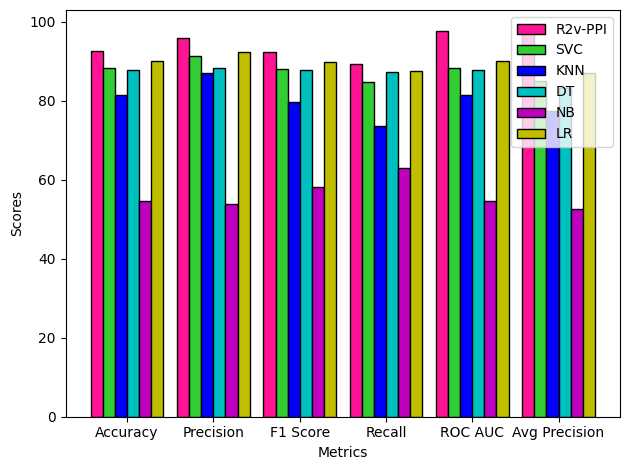

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Accuracy', 'Precision', 'F1 Score', 'Recall', 'ROC AUC', 'Avg Precision']
#metrics = ['CNN-FE-PPI','SVC','KNN','DT','NB','LR']
acc_proposed = [92.65, 95.86, 92.39, 89.17, 97.54, 98.02]
pre_proposed = [88.34, 91.34, 87.91, 84.75, 88.34, 85.02]
f1_score = [81.31, 87.08, 79.73, 73.54, 81.31, 77.27]
recall = [87.75, 88.18, 87.67, 87.18, 87.75, 83.29]
roc_auc_score = [54.61, 53.95, 58.11, 63.05, 54.61, 52.49]
avg_pre_score = [90.05, 92.17, 89.80, 87.54, 90.05, 86.92]

# Set the width of the bars
bar_width = 0.14

# Set the x-axis positions
index = np.arange(len(metrics))

# Create a bar for each metric
plt.bar(index, acc_proposed, bar_width,color = 'deeppink',edgecolor = 'black', label='R2v-PPI')
plt.bar(index + bar_width, pre_proposed, bar_width,color = 'limegreen',edgecolor = 'black', label='SVC')
plt.bar(index + 2 * bar_width, f1_score, bar_width,color = 'b',edgecolor = 'black', label='KNN')
plt.bar(index + 3 * bar_width, recall, bar_width,color = 'c',edgecolor = 'black', label='DT')
plt.bar(index + 4 * bar_width, roc_auc_score, bar_width,color = 'm',edgecolor = 'black', label='NB')
plt.bar(index + 5 * bar_width, avg_pre_score, bar_width,color = 'y',edgecolor = 'black', label='LR')

# Set the x-axis labels
plt.xlabel('Metrics')
plt.xticks(index + 2.5 * bar_width, metrics)

# Set the y-axis label
plt.ylabel('Scores')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

data = {
    'Model': ['CNN-FE-PPI', 'SVC', 'KNN', 'DT', 'NB', 'LR'],
    'Accuracy': [92.65, 88.34, 81.31, 87.75, 54.61, 90.05],
    'Precision': [95.86, 91.34, 87.08, 88.18, 53.95, 92.17],
    'Recall': [89.17, 84.75, 73.54, 87.18, 63.05, 87.54],
    'F1 Score': [92.39, 87.91, 79.73, 87.67, 58.11, 89.80],
    'ROC AUC': [97.54, 88.34, 81.31, 87.75, 54.61, 90.05],
    'ROC PR': [98.02, 85.02, 77.27, 83.29, 52.49, 86.92]
}

df = pd.DataFrame(data)

print(df)


        Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  ROC PR
0  CNN-FE-PPI     92.65      95.86   89.17     92.39    97.54   98.02
1         SVC     88.34      91.34   84.75     87.91    88.34   85.02
2         KNN     81.31      87.08   73.54     79.73    81.31   77.27
3          DT     87.75      88.18   87.18     87.67    87.75   83.29
4          NB     54.61      53.95   63.05     58.11    54.61   52.49
5          LR     90.05      92.17   87.54     89.80    90.05   86.92
